In [2]:
import jax.numpy as jnp
import jax
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import equinox as eqx
jax.config.update('jax_enable_x64',True)
import matplotlib.pyplot as plt

gamma = 1.
omega = 2

beta = 3.
alpha = -3
delta = 0.2


def forcing(t):
    return gamma*jnp.cos(omega*t)

@eqx.filter_jit
def duffing(t,x, args):
    return jnp.array([
        x[1],
        x[2],
        forcing(t) - beta * x[0]**3 - alpha * x[0] - delta * x[1]
    ])


In [6]:
term = ODETerm(duffing)
solver = Dopri5()
saveat = SaveAt(dense=True)
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)
y0 = jnp.array([0,0.0,0.0])
ode_sol = diffeqsolve(
    terms = term, 
    solver = solver, 
    t0=0, t1=2., dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )


E1218 14:08:06.545951 1881278 pjrt_stream_executor_client.cc:3085] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/alexh/miniconda3/envs/kernel_eq/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/alexh/miniconda3/envs/kernel_eq/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/alexh/miniconda3/envs/kernel_eq/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/alexh/miniconda3/envs/kernel_eq/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/alexh/miniconda3/envs/kernel_eq/lib/python3.13/asyncio/base_events.py", line 679, in run_forever
  File "/home/alexh/miniconda3/envs/kernel_eq/lib/python3.13/asyncio/base_events.py", line 2027, in _

EquinoxRuntimeError: Above is the stack outside of JIT. Below is the stack inside of JIT:
  File "/home/alexh/miniconda3/envs/kernel_eq/lib/python3.13/site-packages/diffrax/_integrate.py", line 1423, in diffeqsolve
    sol = result.error_if(sol, jnp.invert(is_okay(result)))
equinox.EquinoxRuntimeError: The maximum number of solver steps was reached. Try increasing `max_steps`.

-------------------

An error occurred during the runtime of your JAX program.

1) Setting the environment variable `EQX_ON_ERROR=breakpoint` is usually the most useful
way to debug such errors. This can be interacted with using most of the usual commands
for the Python debugger: `u` and `d` to move up and down frames, the name of a variable
to print its value, etc.

2) You may also like to try setting `JAX_DISABLE_JIT=1`. This will mean that you can
(mostly) inspect the state of your program as if it was normal Python.

3) See `https://docs.kidger.site/equinox/api/debug/` for more suggestions.


In [517]:
ode_sol.evaluate(10.)

Array([-0.35933522,  1.89119628], dtype=float64)

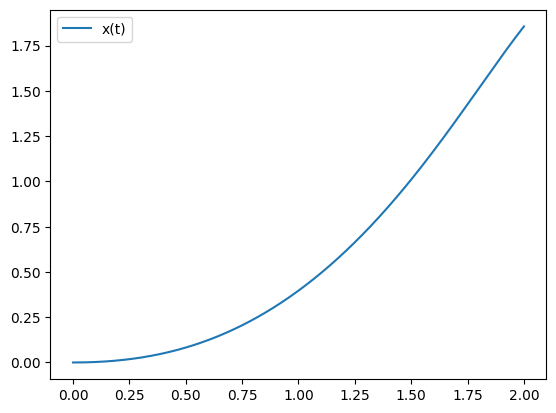

In [5]:
tvals = jnp.linspace(0,2,5000)
y_full = jax.vmap(ode_sol.evaluate)(tvals)
plt.plot(tvals,y_full[:,0],label = 'x(t)')
#plt.plot(tvals,y_full[:,1],label = "x'(t)")
plt.legend()

In [606]:
num_obs = 50
obs_times = jnp.linspace(0,25,num_obs)

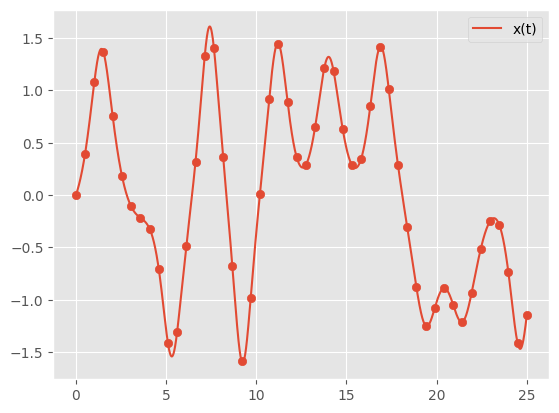

In [607]:
tvals = jnp.linspace(0,25,5000)
y_full = jax.vmap(ode_sol.evaluate)(tvals)
plt.plot(tvals,y_full[:,0],label = 'x(t)')

y_obs = jax.vmap(ode_sol.evaluate)(obs_times)[:,0]
plt.scatter(obs_times,y_obs)
plt.legend()

In [608]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import CholInducedRKHS,OperatorModel,CholOperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data
)
from plotting import plot_input_data,plot_compare_error

In [609]:
t_obs = obs_times.reshape(-1,1)

In [610]:
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    fit_kernel_params,
    get_gaussianRBF
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel,InducedOperatorModel
from functools import partial
from Kernels import log1pexp,inv_log1pexp

def dtt_k(k,index = 0):
    return dt_k(dt_k(k,index),index)

u_operators = (eval_k,dt_k,dtt_k)

feature_operators = (eval_k,dt_k)

k_u = get_gaussianRBF(0.5)
num_colloc = 1000
t_grid = jnp.linspace(0,25,num_colloc).reshape(-1,1)


u_model = CholInducedRKHS(
    t_grid,
    u_operators,
    k_u,
    nugget_size = 1e-8
    )

u_params_init = u_model.get_fitted_params(t_obs,y_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,t_grid,u_params_init))
    .reshape(
            len(t_grid),
            len(feature_operators),
            order = 'F'
        )
)
grid_features_init = jnp.hstack([t_grid,grid_features_init])

num_P_inducing = 500
P_inducing_points = jax.random.choice(jax.random.PRNGKey(13),grid_features_init,(num_P_inducing,))

k_P_u_part = get_gaussianRBF(1.)
def k_P(x,y):
    return k_P_u_part(x[1:],y[1:])
P_model = InducedOperatorModel(P_inducing_points,k_P)

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (t_obs,),
    (y_obs,),
    (t_grid,),
    feature_operators,
    rhs_operator=dtt_k,
    datafit_weight = 100,
    rhs_forcing_values = (-forcing(t_grid)[:,0],),
    num_P_operator_params = 500
)

utt_init = EqnModel.apply_rhs_op_single(u_model,u_params_init,EqnModel.collocation_points[0])-forcing(t_grid)[:,0]
P_params_init = P_model.get_fitted_params(grid_features_init,utt_init,lam = 1e-3)
params_init = jnp.hstack([u_params_init,P_params_init])

In [611]:
from Optimizers import CholeskyLM,LMParams

In [612]:
optParams = LMParams(max_iter = 201,min_alpha = 1e-9)
sol,conv = CholeskyLM(params_init,EqnModel,1e-12,optParams = optParams)

  0%|          | 0/201 [00:00<?, ?it/s]

Iteration 0, loss = 0.007869, gradnorm = 0.1386, alpha = 2.5, improvement_ratio = 1.0
Iteration 1, loss = 0.005897, gradnorm = 0.09084, alpha = 2.083, improvement_ratio = 1.0
Iteration 2, loss = 0.004637, gradnorm = 0.06448, alpha = 1.736, improvement_ratio = 1.0
Iteration 3, loss = 0.003797, gradnorm = 0.04744, alpha = 1.447, improvement_ratio = 1.0
Iteration 4, loss = 0.00323, gradnorm = 0.03546, alpha = 1.206, improvement_ratio = 1.0
Iteration 5, loss = 0.002847, gradnorm = 0.02663, alpha = 1.005, improvement_ratio = 1.0
Iteration 50, loss = 0.001038, gradnorm = 0.0001492, alpha = 0.0002747, improvement_ratio = 0.9998
Iteration 100, loss = 4.907e-07, gradnorm = 1.731e-05, alpha = 3.019e-08, improvement_ratio = 0.9967
Iteration 150, loss = 1.005e-08, gradnorm = 3.393e-08, alpha = 8.333e-10, improvement_ratio = 0.9999


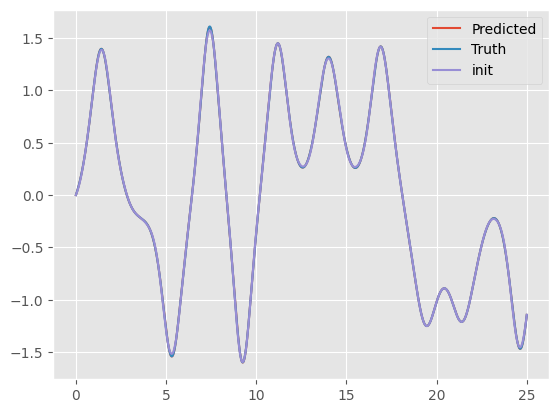

In [613]:
plt.plot(t_grid,u_model.point_evaluate(t_grid,EqnModel.get_u_params(sol)[0]),label = 'Predicted')
plt.plot(tvals,y_full[:,0],label = 'Truth')
plt.plot(t_grid,u_model.point_evaluate(t_grid,u_params_init),label = 'init')

plt.legend()

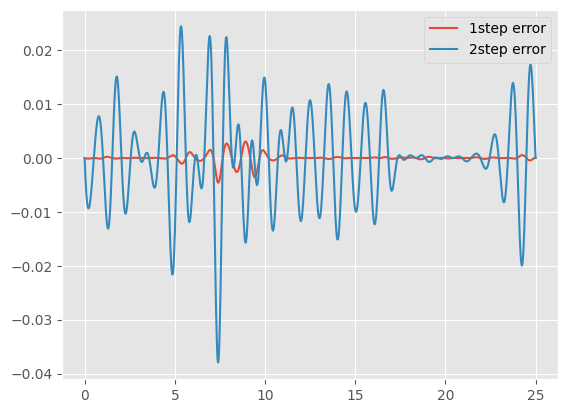

In [622]:
plt.plot(t_grid,u_model.point_evaluate(t_grid,EqnModel.get_u_params(sol)[0])-jax.vmap(ode_sol.evaluate)(t_grid[:,0])[:,0],label = '1step error')
plt.plot(t_grid,u_model.point_evaluate(t_grid,u_params_init)-jax.vmap(ode_sol.evaluate)(t_grid[:,0])[:,0],label = '2step error')
plt.legend()

In [617]:
fitted_P_params = EqnModel.get_P_params(sol)

def learned_vf(t,x,args):
    input = jnp.hstack([t,x]).reshape(1,-1)
    return jnp.array([x[1],P_model.predict(input,fitted_P_params)[0] + forcing(t)])

def init_vf(t,x,args):
    input = jnp.hstack([t,x]).reshape(1,-1)
    return jnp.array([x[1],P_model.predict(input,P_params_init)[0] + forcing(t)])

In [618]:
new_initcon = jnp.array([-0.3,0.5])

In [619]:
y0 = jnp.array([0.,0.5])
term = ODETerm(duffing)
fitted_term = ODETerm(learned_vf)
init_term = ODETerm(init_vf)

ode_truth = diffeqsolve(
    terms = term, 
    solver = solver, 
    t0=0, t1=26, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

ode_fitted = diffeqsolve(
    terms = fitted_term, 
    solver = solver, 
    t0=0, t1=26, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

ode_init = diffeqsolve(
    terms = init_term, 
    solver = solver, 
    t0=0, t1=26, dt0=0.001, 
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps = 50000
    )

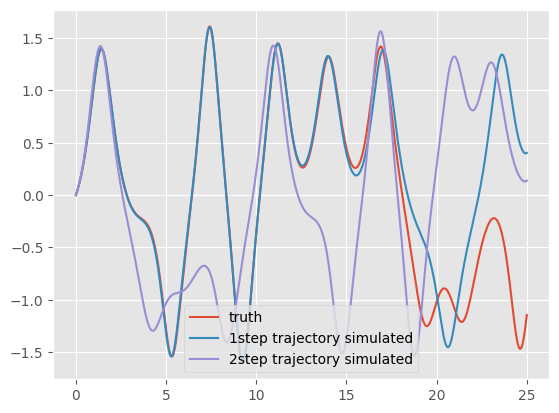

In [623]:
tvals = jnp.linspace(0,25,5000)
plt.plot(tvals,jax.vmap(ode_truth.evaluate)(tvals)[:,0],label = 'truth')
plt.plot(tvals,jax.vmap(ode_fitted.evaluate)(tvals)[:,0],label = '1step trajectory simulated')
plt.plot(tvals,jax.vmap(ode_init.evaluate)(tvals)[:,0],label = '2step trajectory simulated')
plt.legend()
